### This Notebook plots good settings

In [54]:
# Bonus cell for using the different test set

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

# Två delar:
# 1: fixa segmentstorleken
# 2: fixa masker för varje segment
# Eller egentligen, skit i det. Applicera masken i förväg?


def getTestObjects(porositythreshold=0.5): 
    objectwidth = 100
    objectheight = 100
    xspacing = 116
    yspacing = 300
    xstart = 293
    ystart = 445
    xend = 1730
    yend = 1770
    powderthickness = 80
    endlayer = 225
    vsegments = [0, 150, 187, endlayer]

    paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
    paths_sorted = [x for x in paths]
    paths_sorted.sort()
    integrals = np.array([np.array(plt.imread(path)) for path in paths_sorted])

    objectinfo = pd.read_csv('Parameters2.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
    objectinfo = coorddf.join(objectinfo)

    objectinfo.replace('GOOD', 0, inplace=True)
    objectinfo.replace('LOF', 1, inplace=True)
    objectinfo.reset_index(drop=True, inplace=True)

    objects = np.full((len(objectinfo), endlayer, objectheight, objectwidth), np.nan)

    for index, object in objectinfo.iterrows():
        objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]

    rtn = np.full(objects.shape, np.nan)
    aggregate = np.sum(objects, axis=(0))

    emptyRatio = 30
    limit = np.percentile(aggregate, emptyRatio)
    testmask = aggregate >= limit
    for object in objects:
        object[~testmask] = np.nan

    # Create the good frame
    segmentdf = pd.read_csv('Segments2.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity"])
    segmentdf.insert(1, "VED", segmentdf.P * 1000/(segmentdf.S * segmentdf.H * powderthickness))
    segmentdf.insert(1, "Label", np.where(segmentdf.Porosity > porositythreshold, 1, 0))
    # segmentdf.drop(segmentdf[(segmentdf.VED > 50)].index, inplace=True)
    segmentdf.reset_index(drop=True, inplace=True)
    vs = [[vsegments[j], vsegments[j+1]] for i in range(0, len(objects)) for j in reversed(range(0, len(vsegments)-1))]
    coorddf = pd.DataFrame(vs, columns=['zstart', 'zend'])
    testobjectinfo = coorddf.join(segmentdf)
    testobjectinfo.drop(testobjectinfo[(testobjectinfo.Objectnumber == 28) | (testobjectinfo.Objectnumber == 21) ].index, inplace=True)
    testobjectinfo.reset_index(drop=True, inplace=True)

    testobjects = [objects[object.Objectnumber-1, object.zstart:object.zend] for index, object in testobjectinfo.iterrows()]

    del objects
    del objectinfo
    del coorddf
    del objectCoordinates
    del paths_sorted
    del integrals
    print("fetching data with ", porositythreshold)
    return testobjects, testobjectinfo

In [55]:
# Read train data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

def getTrainObjects(objectsplit=1, upsamplingratio=1, positive_multiplier=1, porositythreshold=0.5, separate_test=True):
    emptyRatio = 47
    objectwidth = 83
    objectheight = 122
    xspacing = 133
    yspacing = 270
    xstart = 293
    ystart = 268
    xend = 1730
    yend = 1770
    hsegments = [0,26,50,74,98,122]
    powderthickness = 80
    endlayer = 187

    paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
    paths_sorted = [x for x in paths]
    paths_sorted.sort()
    block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
    integrals = block[0:endlayer]

    del paths_sorted
    objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])

    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
    objectinfo = coorddf.join(objectinfo)

    objects = np.full((len(objectinfo), endlayer, objectheight, objectwidth), np.nan)

    for index, object in objectinfo.iterrows():
        objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]

    aggregate = np.sum(objects, axis=(0,1))

    emptyRatio = 47
    limit = np.percentile(aggregate, emptyRatio)
    mask = aggregate >= limit
    mask = np.repeat([mask], endlayer, 0)

    for object in objects:
        object[~mask] = np.nan

    # Time to construct the "real" dataframe

    segmentdf = pd.read_csv('Segments.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity", "Area"])
    segmentdf.insert(1, "VED", segmentdf.P * 1000/(segmentdf.S * segmentdf.H * powderthickness))
    segmentdf.insert(1, "Label", np.where(segmentdf.Porosity > porositythreshold, 1, 0))
    originalframe = segmentdf.copy()
    hs = [[hsegments[j], hsegments[j+1]] for i in range(0, len(objects)) for j in range(0, len(hsegments)-1)]
    coorddf = pd.DataFrame(hs, columns=['hstart', 'hend'])
    segmentdf = coorddf.join(segmentdf)

    # Start of object multiplication 
    layersPerObject = endlayer // objectsplit
    testEnd = endlayer if separate_test else endlayer - layersPerObject * (objectsplit // 3)
    zs = [segmentdf.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject+1, layersPerObject//(upsamplingratio * positive_multiplier))]
    testzs = [segmentdf.copy().assign(zstart=testEnd, zend=endlayer)]
    trainobjectinfo = pd.concat(zs, ignore_index=True)
    trainobjectinfo.drop(trainobjectinfo[(trainobjectinfo.Objectnumber == 28) | (trainobjectinfo.Objectnumber == 21) ].index, inplace=True)
    trainobjectinfo.reset_index(drop=True, inplace=True)
    testobjectinfo = pd.concat(testzs, ignore_index=True)
    testobjectinfo.drop(testobjectinfo[(testobjectinfo.Objectnumber == 28) | (testobjectinfo.Objectnumber == 21) ].index, inplace=True)
    testobjectinfo.reset_index(drop=True, inplace=True)

    # Removes extra rows 
    trainobjectinfo = trainobjectinfo[(trainobjectinfo['Label'] == 1) | (trainobjectinfo['zstart'] % (positive_multiplier) == 0)]

    trainobjects = [objects[object.Objectnumber-1, object.zstart:object.zend, object.hstart:object.hend] for index, object in trainobjectinfo.iterrows()]
    testobjects = [objects[object.Objectnumber-1, object.zstart:object.zend, object.hstart:object.hend] for index, object in testobjectinfo.iterrows()]

    print("fetching data with objectsplit: {}, upsamplingratio: {}, positive_multiplier: {}, porositythreshold: {}".format(objectsplit, upsamplingratio, positive_multiplier, porositythreshold))
    return trainobjects, trainobjectinfo, testobjects, testobjectinfo

# assert(np.average(np.isfinite(trainobjects)) == 1)
# assert(np.average(np.isfinite(testobjects)) == 1)
# xs = np.copy(aggregate)
# xs[~backgroundmask] = np.nan
# plt.imshow(xs)
# plt.figure()

In [56]:
from sklearn import neighbors, metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from datetime import datetime
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import tree
import warnings

def preprocess(objects, type, sharpening):
    rtn = []
    # print(rtn.shape)
    for index, object in enumerate(objects):
        object = np.copy(object)
        sharpened = object
        if(sharpening != 'none'):
            sharpeningKernel = np.array([   [-1, -1,  -1],
                                        [-1,  9,  -1],
                                        [ -1, -1,  -1]
        ]) if sharpening == 'diagonal' else np.array([  [0, -1,  0],
                                                        [-1, 5, -1],
                                                        [0, -1,  0]])
            sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in object])
        # Sharpening is done
        if type == 'scatter' or type == 'spatstat':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            rtn.append(xs)
        elif type == 'moran':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            avg = np.nanmean(xs)
            stddev = np.nanstd(xs)
            xs = (xs - avg) / avg
            rtn.append(xs)
    return rtn


def calculateoutliers(objects, type, neighbourhoodSetting, windowSize):
    # c, z, y, x = objects.shape
    outlierValues = []
    index = 0
    # return objects
    for object in objects:
        object = np.copy(object)
        z, y, x = object.shape
        # Step 1: calculate neighbourhood
        neighbourkernel = np.ones((neighbourhoodSetting, neighbourhoodSetting)) / neighbourhoodSetting**2
        flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in object])
        neighbourhoodValues = np.array([
            np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
            for layerIndex in range(windowSize, z+1)
        ])
        # Step 2: calculate outlier
        offset = windowSize // 2
        endoffset = windowSize - offset - 1

        ys = neighbourhoodValues[0:z-windowSize+1]
        xs = object[offset:z-endoffset]
        filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))

        # plt.imshow(xs[0])
        # plt.figure()
        # plt.imshow(xs[0])
        # plt.figure()
        # if(index == 58):
        #     plt.imshow(xs[0])
        #     plt.figure()
        #     plt.imshow(ys[0])
        #     plt.figure()
        #     plt.imshow(filter[0])
        #     plt.figure()
        #     print(len(np.unique(filter)))
        numberOfFilterValues = len(np.unique(filter))
        # print("filterlength is: ", numberOfFilterValues)
        # print("index is:", index)
        assert numberOfFilterValues == 2, f"Expected filter to have two values, got: {numberOfFilterValues}"
        if type == 'spatstat':
            outliers = xs - ys
            avg = np.mean(outliers[filter])
            std = np.std(outliers[filter])
            outliers = (outliers - avg) / std
            outlierValues.append(outliers)
        else:
            with warnings.catch_warnings():
                line = np.polyfit(xs[filter].flatten(), ys[filter].flatten(), 1)
                p = np.poly1d(line)
                outlierValues.append(p(xs) - ys)
            assert(xs.shape == p(ys).shape)
        assert(len(np.unique(outlierValues[index])) > 1)
        assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
        index+=1
    return outlierValues

def encode(outlierobjects, buckets, minval=0, maxval=0):
    numberOfObjects = len(outlierobjects)
    X = np.full((numberOfObjects, buckets), np.nan)
    raw = np.concatenate([oo.flatten() for oo in outlierobjects])
    filter = np.isfinite(raw)
    minval = np.min(raw[filter]) if minval == 0 else minval
    maxval = np.max(raw[filter]) if maxval == 0 else maxval
    for index in range(0, numberOfObjects):
        xs = outlierobjects[index]
        filter = np.isfinite(xs)
        hist, edges = np.histogram(xs[filter], bins=buckets, range=(minval, maxval), density=True)
        X[index] = np.array(hist)
    
    return X, minval, maxval, edges

def classify(Xtrain, Ytrain, Xtest, Ytest, type, n_neighbors):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform", n_jobs=-1) if type == 'KNN' else tree.DecisionTreeClassifier(max_depth=n_neighbors*2, class_weight='balanced', random_state=42)
    clf2 = clf
    scaler = StandardScaler()
    clf = Pipeline([('scaler', scaler), ('classifier', clf)])
    # cvs = cross_val_score(clf, Xtrain, Ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
    clf.fit(Xtrain, Ytrain)
    Yfit = clf.predict(Xtest)
    Yprobs = clf.predict_proba(Xtest)
    Xtransformed = scaler.transform(Xtest)

    return Yfit, Yprobs, clf2.kneighbors(Xtransformed) if type == 'KNN' else np.array([])
    # How do we return values for the POD?
    # We want to return the ratio...

In [57]:
from sklearn import metrics

# Now to tie it all together...

def getPodAndRoc (Xtrain, Ytrain, Xtest, Ytest, classifier, type, z, xy, bins, hyperparameter):
    sharpSetting = 'none'

    trainpreprocessed =preprocess(Xtrain, type, sharpSetting)
    testpreprocessed =preprocess(Xtest, type, sharpSetting)

    trainoutliers = calculateoutliers(trainpreprocessed, type, xy, z)
    testoutliers = calculateoutliers(testpreprocessed, type, xy, z)

    Xtrain, minval, maxval, edges = encode(trainoutliers, bins)
    Xtest, _, _, _ = encode(testoutliers, bins, minval=minval, maxval=maxval)

    # Print in the classify function, can't do it outside? 
    Ypred, Yprobs, neighbours = classify(Xtrain, Ytrain, Xtest, Ytest, classifier, hyperparameter)
    
    # limits = np.logspace(-1, 1, num=20)
    # limits = np.array([0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2])

    # recall = [metrics.recall_score(np.where(testobjectinfo.Porosity > limit, 1, 0), Ypred) for limit in limits ]
    # precision = [metrics.precision_score(np.where(testobjectinfo.Porosity > limit, 1, 0), Ypred) for limit in limits ]
    
    return Ypred, Yprobs[:,1], neighbours

In [70]:
# Starting with B/V-set evaluation (AKA A)

from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay


settingcolumns = ['threshold', 'classifier', 'type', 'z', 'xy', 'bins', 'hyperparameter',]
settings =  pd.DataFrame([
    [0.1,'KNN','moran',1,7,20,5,],
    [0.1,'KNN','moran',1,5,20,11,],
    [0.1,'KNN','spatstat',1,5,5,5,],
    [0.25,'KNN','moran',1,7,40,7,],
    [0.25,'KNN','moran',1,5,40,11,],
    [0.25,'KNN','moran',1,3,10,7,],
    [0.5,'KNN','spatstat',1,7,40,11,],
    [0.5,'KNN','moran',1,7,40,7,],
    [0.5,'KNN','moran',1,5,40,11,],
], columns=settingcolumns)
for threshold in [0.1, 0.25, 0.50]:
# for threshold in [0.25]:
    trainobjects, trainobjectinfo, testobjects, testobjectinfo = getTrainObjects(porositythreshold=threshold, separate_test=True)
    testobjects, testobjectinfo = getTestObjects(porositythreshold=threshold)
    Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
    Ytest = np.array(testobjectinfo.loc[:,"Label"])
    scoresMap = {}
    for index, object in settings[settings.threshold == threshold].iterrows():
        name = "Moran scatter plot" if object.type == "moran" else "Spatial statistics" if object.type == "spatstat" else "Scatter plot"
        Ypred, Yprobs, neighbours = getPodAndRoc(trainobjects, Ytrain, testobjects, Ytest, object.classifier, object.type, object.z, object.xy, object.bins, object.hyperparameter)
        fpr , tpr, thresholds = roc_curve(Ytest, Yprobs)
        auc = roc_auc_score(Ytest, Yprobs)
        f1 = metrics.f1_score(Ytest, Ypred)
        hashname = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy}'
        # label = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy}, Bins={object.bins} (AUC={auc:.3f}, F1={f1:.3f})'
        label = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy} (AUC={auc:.3f})'
        for i in range(0, len(fpr)):
            if tpr[i] == 1 or fpr[i+1] > 0.2:
                scoresMap[hashname] = (np.where(Yprobs >= thresholds[i], 1, 0), Yprobs)
                plt.plot(fpr, tpr, label=label, markevery=[i], marker='x')
                break



    
    Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
    Ytest = np.array(testobjectinfo.loc[:,"Label"])
    Xtrain = np.array([np.nanmean(object) for object in trainobjects])
    Xtest = np.array([np.nanmean(object) for object in testobjects])
    clf = tree.DecisionTreeClassifier(max_depth=1)
    clf.fit(Xtrain.reshape(-1, 1), Ytrain)
    Ypred = clf.predict(Xtest.reshape(-1, 1))
    Yprobs = clf.predict_proba(Xtest.reshape(-1, 1))[:,1]
    
    auc = roc_auc_score(Ytest, Yprobs)
    fpr , tpr, thresholds = roc_curve(Ytest, Yprobs)
    f1 = metrics.f1_score(Ytest, Ypred)
    # label = f'Baseline (AUC={auc:.3f}, F1={f1:.3f})'
    label = f'Baseline (AUC={auc:.3f})'
    hashname = 'Baseline'
    plt.plot(fpr, tpr, label=label, markevery=[1], marker='x')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fancybox=True)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis('square')
    title = "ROC for threshold " + str(threshold)
    plt.savefig('figures/v3plotter/B/roc_' + str(threshold) + '.png', dpi=300, bbox_inches='tight')
    plt.title(title)
    plt.figure()
    scoresMap[hashname] = (Ypred, Yprobs)
    plt.rc('font', size=48)          # controls default text sizes
    plt.rc('axes', titlesize=24)     # fontsize of the axes title
    plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=24)    # fontsize of the tick labels

    # Confusion matricies
    for key in scoresMap.keys():
        Ypred, Yprobs = scoresMap[key]
        Ytest = np.array(testobjectinfo.loc[:,"Label"])
        cm = metrics.confusion_matrix(Ytest, Ypred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Solid", "Porous"])
        disp.plot()
        title = "Confusion matrix for threshold: " + str(threshold) +  ", " + key
        plt.savefig('figures/v3plotter/B/confusionmatrix_' + str(threshold) + "_" + key + '.png', dpi=300, bbox_inches='tight')
        plt.title(title)
        plt.figure()
    plt.rcParams.update(plt.rcParamsDefault)

    # Precision recall plot
    for key in scoresMap.keys():
        Ypred, Yprobs = scoresMap[key]
        Ytest = np.array(testobjectinfo.loc[:,"Label"])
        precision, recall, thresholds = metrics.precision_recall_curve(Ytest, Yprobs)
        plt.plot(recall, precision, label=key)
    plt.axis('square')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fancybox=True)
    title = "precision-recall plot for porosity threshold " + str(threshold) + "%"
    plt.savefig('figures/v3plotter/B/precision-recall' + str(threshold) + '.png', dpi=300, bbox_inches='tight')
    plt.title(title)
    plt.figure()

    # POD plot
    # limits = np.logspace(-2, 2, num=13)*threshold
    limits = np.logspace(-2, 2, num=9)*threshold
    limits[0] = 0
    limits[-1] = 30
    plt.grid()
    for (index, key) in enumerate(scoresMap.keys()):
        Ypred, Yprobs = scoresMap[key]
        Ytest = np.array(testobjectinfo.loc[:,"Label"])
        recall = [metrics.recall_score(np.where((testobjectinfo.Porosity < limit1) & (testobjectinfo.Porosity > limit2), 1, 0), Ypred) for (limit1, limit2) in zip(limits[1:], limits[:-1]) ]
        plt.step(limits[1:], recall, where='pre', label=key, linestyle=(-index*2, (3, 5)), zorder=10-index, linewidth=3, alpha=0.8)
    plt.plot([0, threshold, threshold, limits[-1]], [0, 0, 1, 1], label= "Ideal classifier", c='black', zorder=0)
    plt.xlabel("Sample Porosity, a %")
    plt.ylabel("Probability of Detection, POD|a")
    plt.xscale('log')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fancybox=True)
    title = "POD for porosity threshold " + str(threshold) + "%"
    plt.savefig('figures/v3plotter/B/POD' + str(threshold) + '.png', dpi=300, bbox_inches='tight')
    plt.title(title)
    plt.figure()

fetching data with objectsplit: 1, upsamplingratio: 1, positive_multiplier: 1, porositythreshold: 0.1
fetching data with  0.1


/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/sklearn/metrics/_classi

fetching data with objectsplit: 1, upsamplingratio: 1, positive_multiplier: 1, porositythreshold: 0.25
fetching data with  0.25


fetching data with objectsplit: 3, upsamplingratio: 1, positive_multiplier: 1, porositythreshold: 0.5


/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_82039/1259696210.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/erik/Git/thesis/

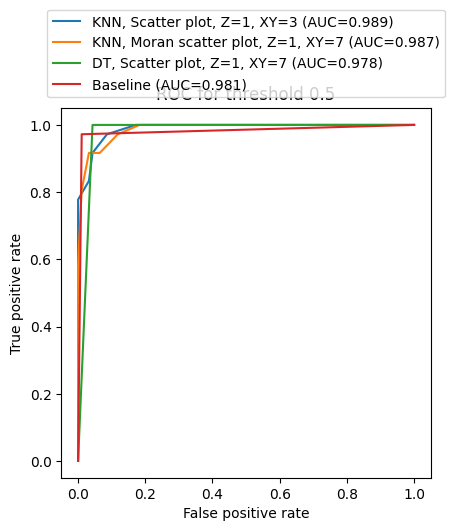

<Figure size 640x480 with 0 Axes>

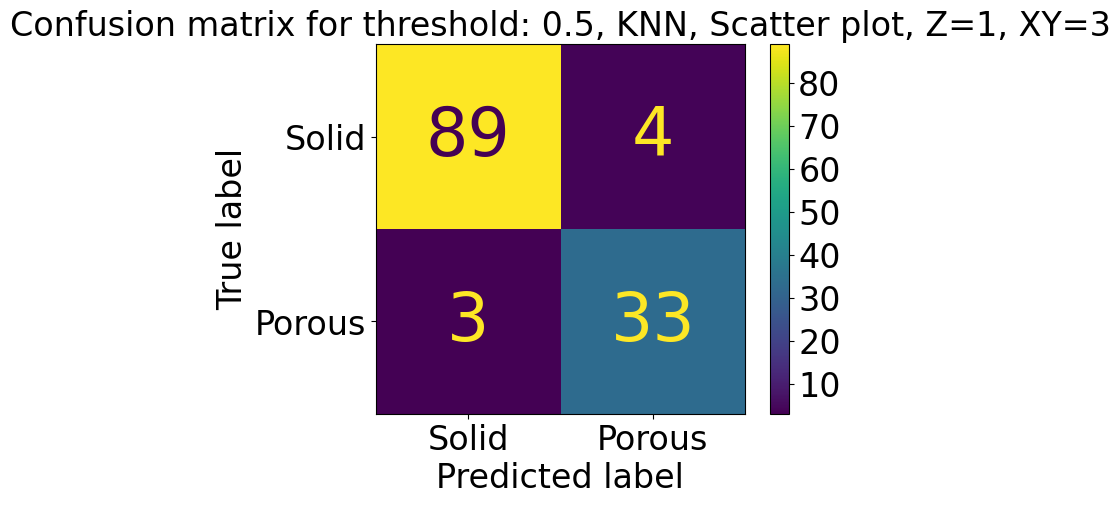

<Figure size 640x480 with 0 Axes>

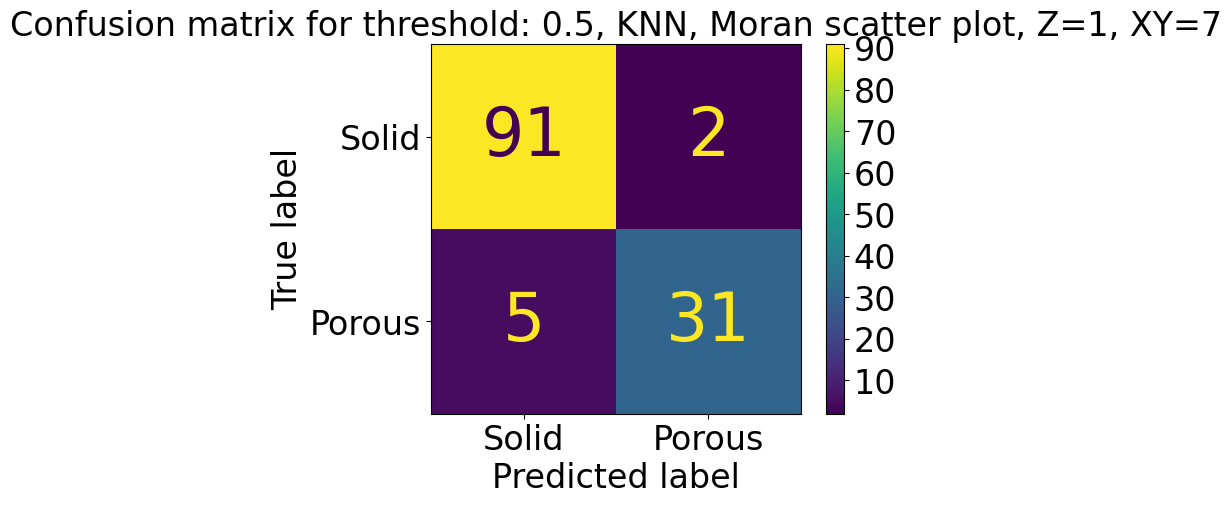

<Figure size 640x480 with 0 Axes>

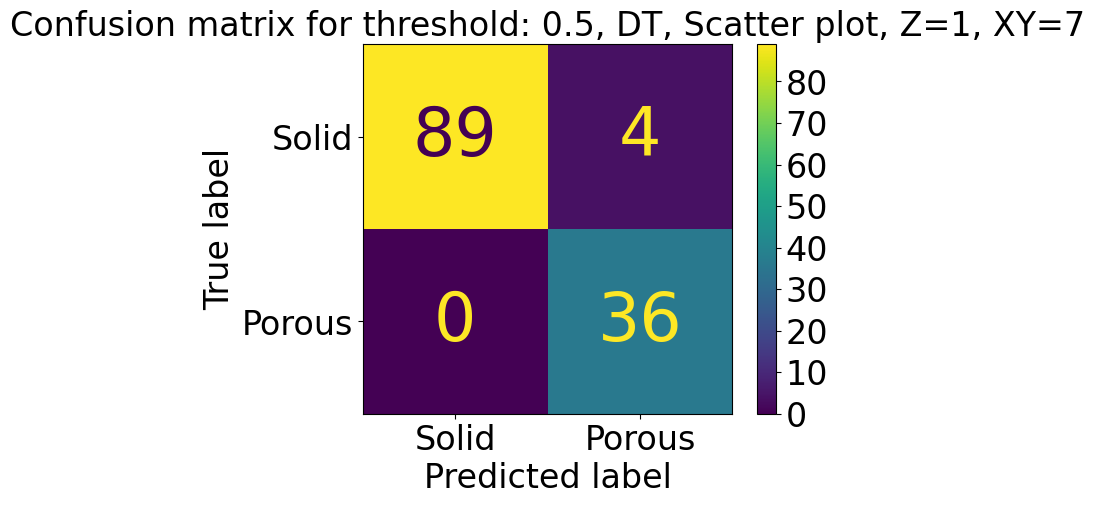

<Figure size 640x480 with 0 Axes>

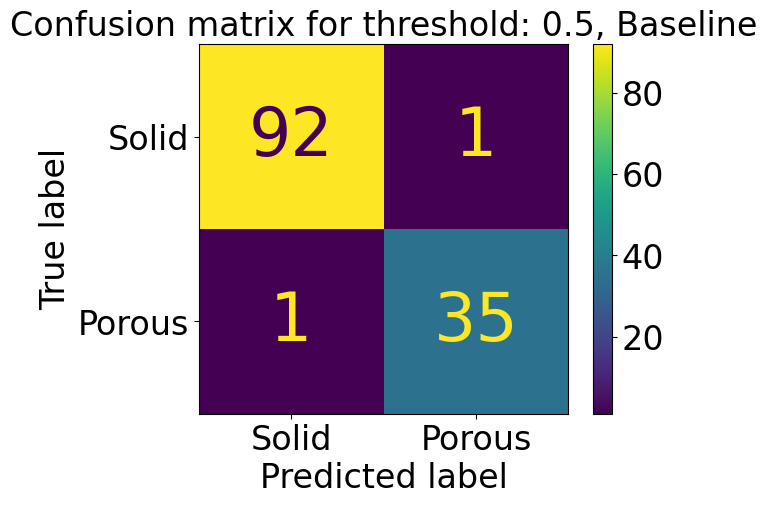

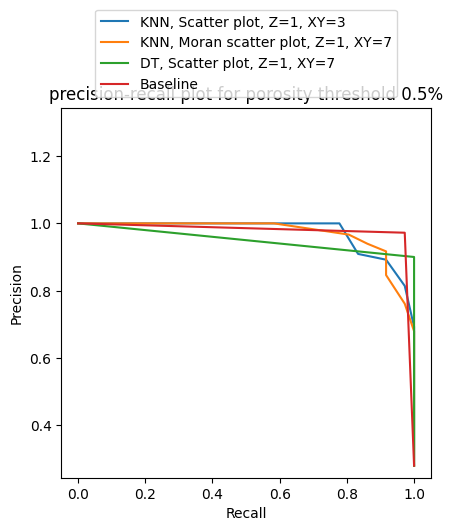

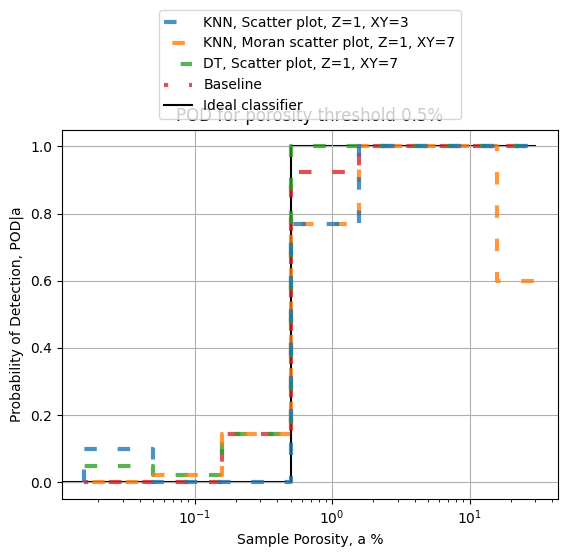

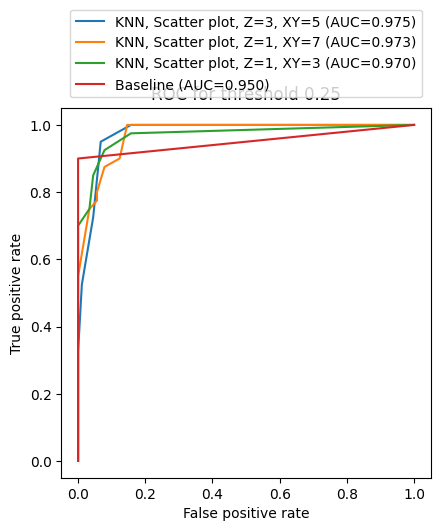

<Figure size 640x480 with 0 Axes>

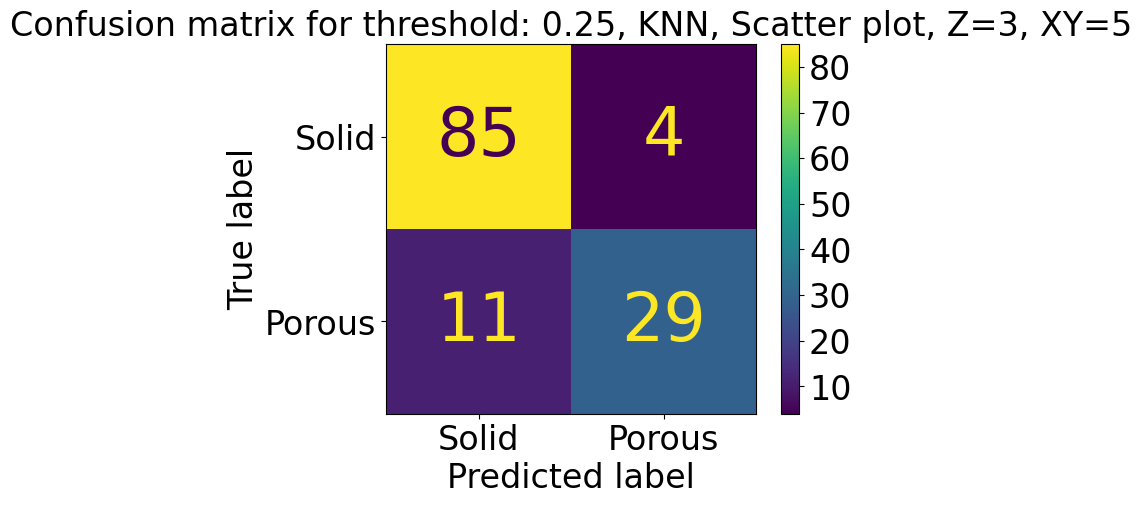

<Figure size 640x480 with 0 Axes>

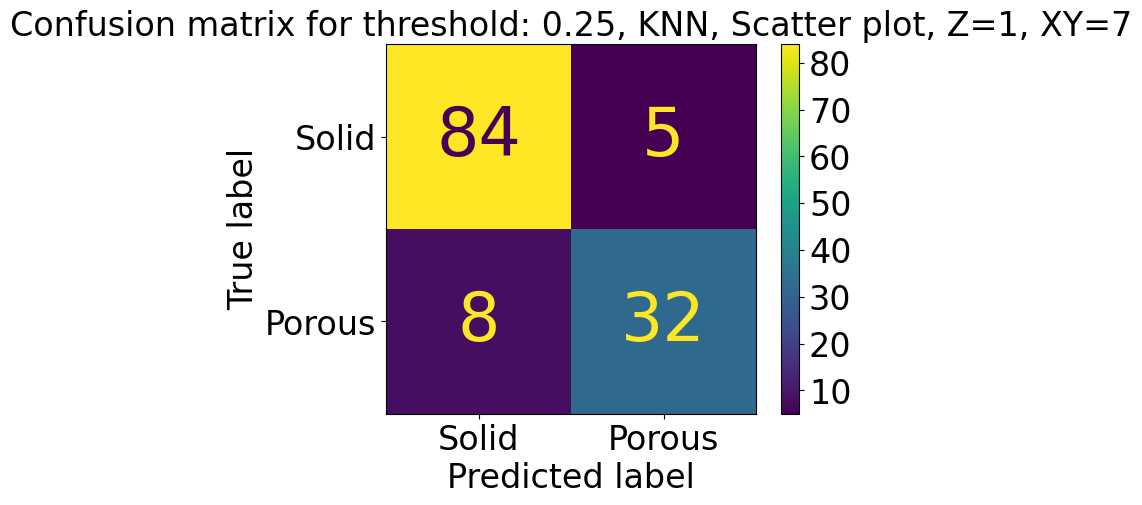

<Figure size 640x480 with 0 Axes>

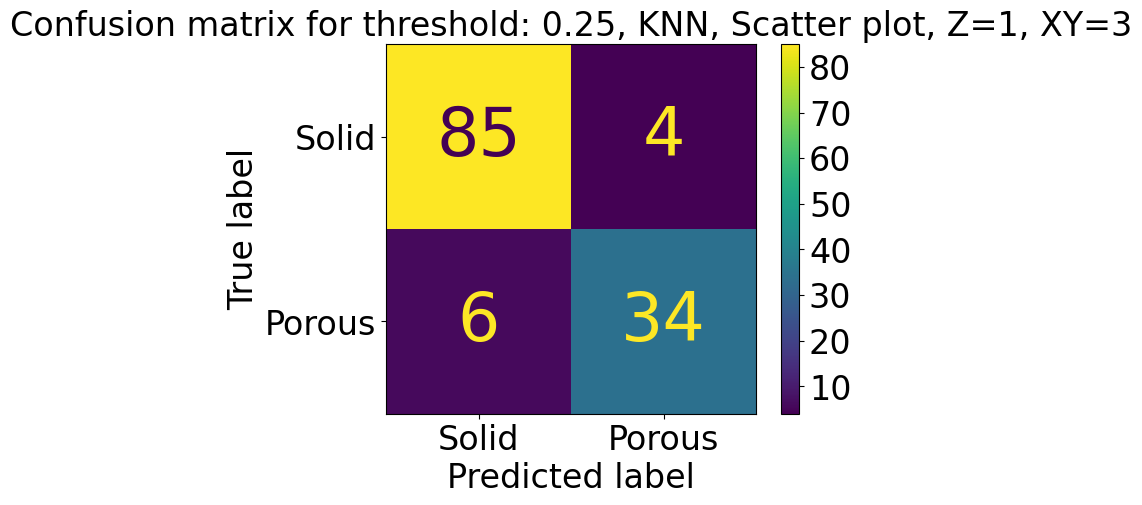

<Figure size 640x480 with 0 Axes>

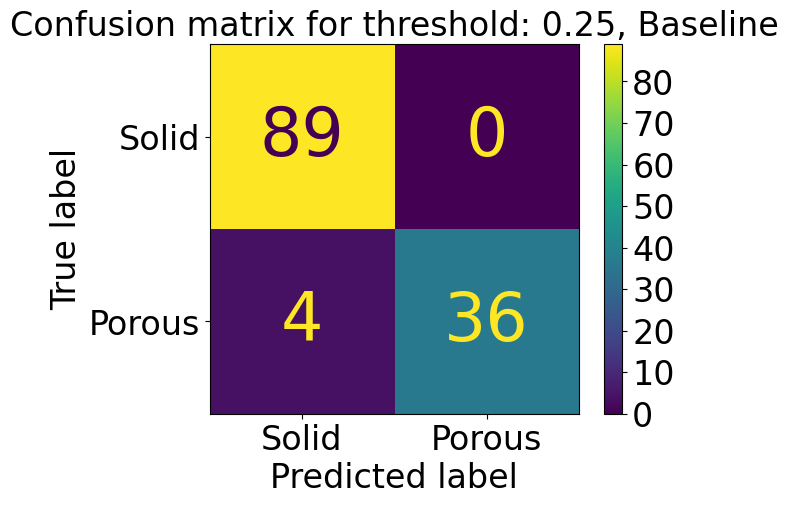

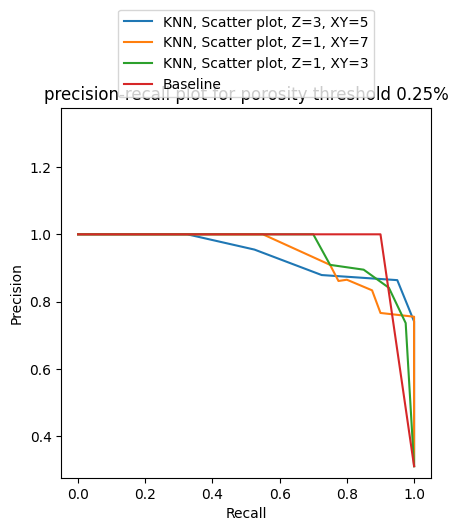

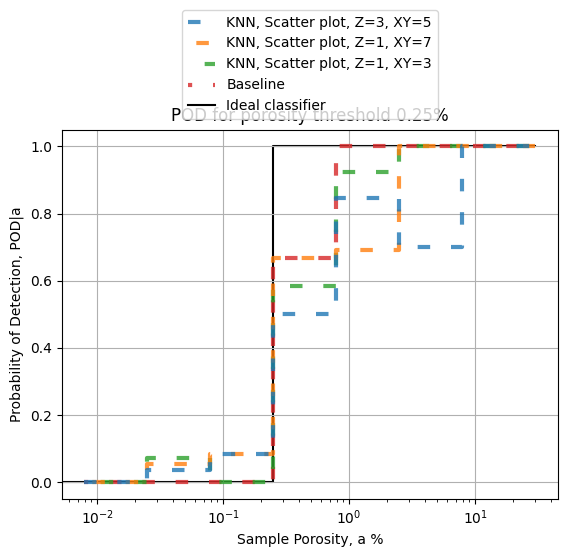

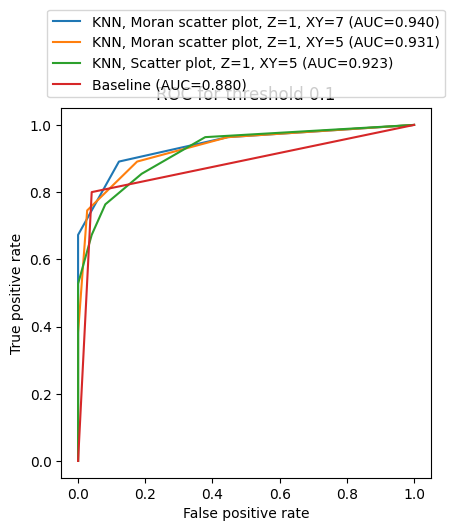

<Figure size 640x480 with 0 Axes>

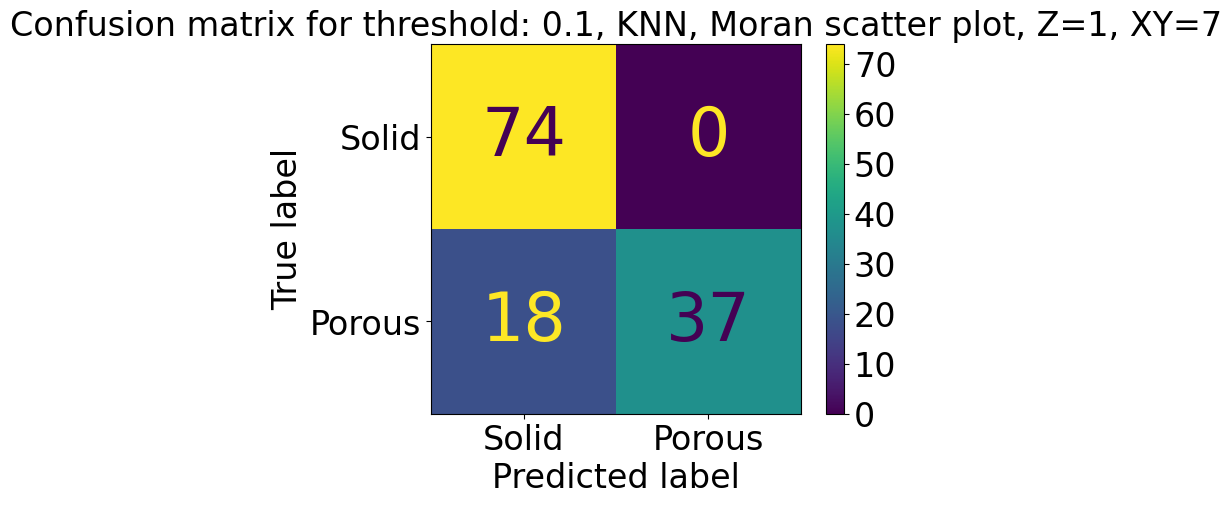

<Figure size 640x480 with 0 Axes>

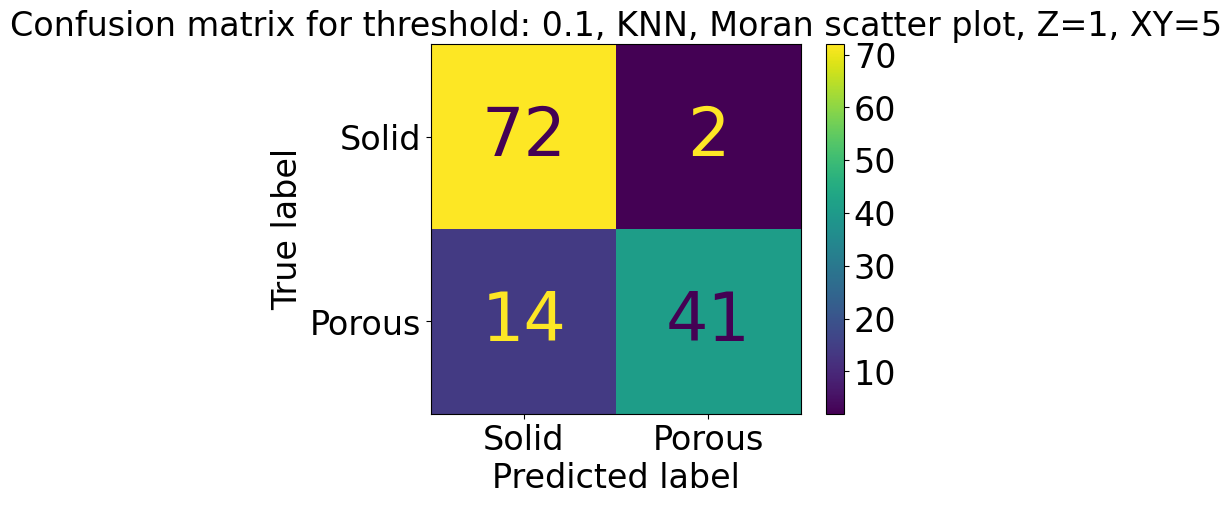

<Figure size 640x480 with 0 Axes>

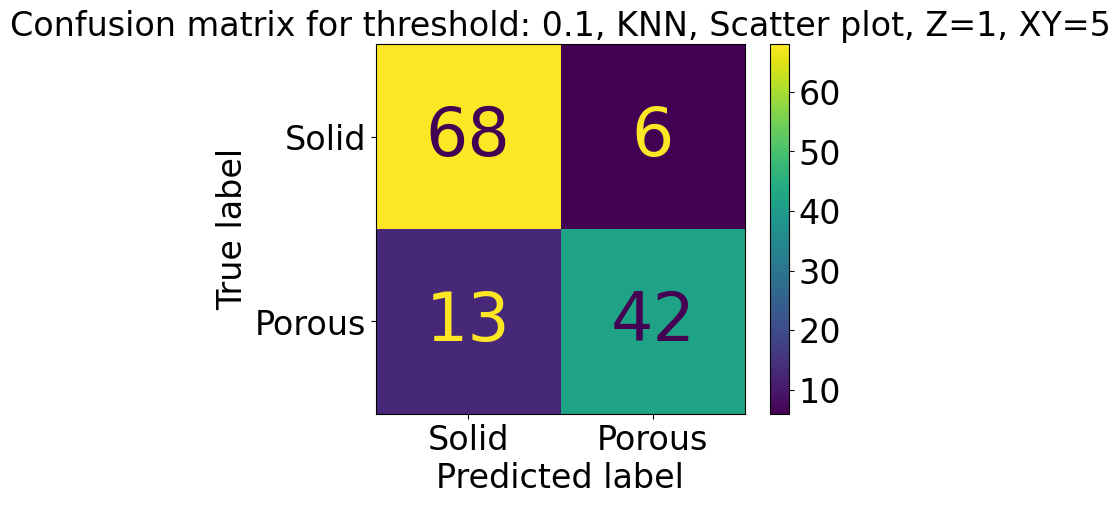

<Figure size 640x480 with 0 Axes>

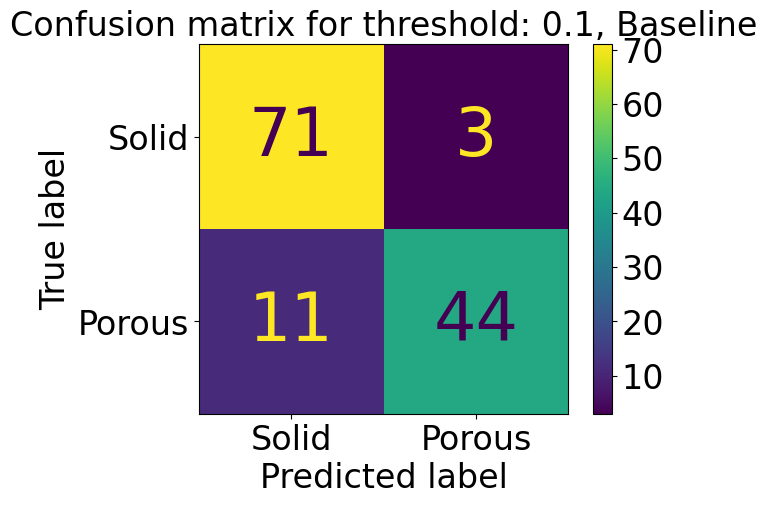

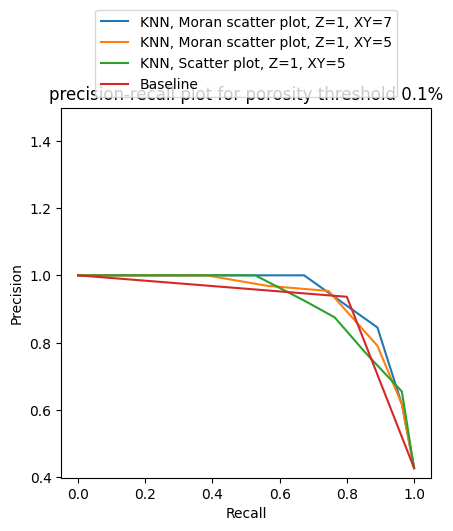

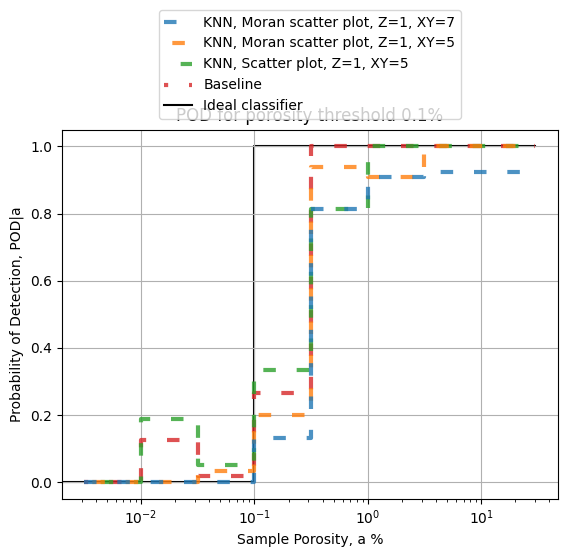

<Figure size 640x480 with 0 Axes>

In [63]:
# Now the A/H-set evaluation
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, LeaveOneOut, train_test_split

settingcolumns = ['threshold', 'classifier', 'type', 'z', 'xy', 'bins', 'hyperparameter']
settings =  pd.DataFrame([
    [0.1,'KNN','moran',1,7,20,5,],
    [0.1,'KNN','moran',1,5,40,5,],
    [0.1,'KNN','scatter',1,5,40,5,],
    [0.25,'KNN','scatter',3,5,40,5,],
    [0.25,'KNN','scatter',1,7,10,7,],
    [0.25,'KNN','scatter',1,3,20,5,],
    [0.5,'KNN','scatter',1,3,20,5,],
    [0.5,'KNN','moran',1,7,40,11,],
    [0.5,'DT','scatter',1,7,40,11,],
], columns=settingcolumns)

trainobjects, trainobjectinfo, testobjects, testobjectinfo = getTrainObjects(porositythreshold=threshold, objectsplit=3, separate_test=True)
for threshold in [0.5, 0.25, 0.1]:
# for threshold in [0.25]:
    Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
    porosity = np.array(trainobjectinfo.loc[:,"Porosity"])
    Xtrain, Xtest, Ytrain, Ytestporosity = train_test_split(trainobjects, porosity, test_size=0.33, random_state=42)
    Ytest = np.where(Ytestporosity > threshold, 1, 0)
    Ytrain = np.where(Ytrain > threshold, 1, 0)
    scoresMap = {}
    for index, object in settings[settings.threshold == threshold].iterrows():
        name = "Moran scatter plot" if object.type == "moran" else "Spatial statistics" if object.type == "spatstat" else "Scatter plot"
        Ypred, Yprobs, neighbours = getPodAndRoc(Xtrain, Ytrain, Xtest, Ytest, object.classifier, object.type, object.z, object.xy, object.bins, object.hyperparameter)
        fpr , tpr, thresholds = roc_curve(Ytest, Yprobs)
        auc = roc_auc_score(Ytest, Yprobs)
        f1 = metrics.f1_score(Ytest, Ypred)
        hashname = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy}'
        # label = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy}, Bins={object.bins} (AUC={auc:.3f}, F1={f1:.3f})'
        label = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy} (AUC={auc:.3f})'
        for i in range(0, len(fpr)):
            if tpr[i] == 1 or fpr[i+1] > 0.2:
                scoresMap[hashname] = (np.where(Yprobs >= thresholds[i], 1, 0), Yprobs)
                plt.plot(fpr, tpr, label=label, markevery=[i], marker='x')
                break

        
    
    clf = tree.DecisionTreeClassifier(max_depth=1)
    TrainMean = np.array([np.nanmean(object) for object in Xtrain])
    TestMean = np.array([np.nanmean(object) for object in Xtest])
    clf.fit(TrainMean.reshape(-1, 1), Ytrain)
    Ypred = clf.predict(TestMean.reshape(-1, 1))
    Yprobs = clf.predict_proba(TestMean.reshape(-1, 1))[:,1]
    auc = roc_auc_score(Ytest, Yprobs)
    fpr , tpr, thresholds = roc_curve(Ytest, Yprobs)
    f1 = metrics.f1_score(Ytest, Ypred)
    # label = f'Baseline (AUC={auc:.3f}, F1={f1:.3f})'
    label = f'Baseline (AUC={auc:.3f})'
    hashname = 'Baseline'
    scoresMap[hashname] = (Ypred, Yprobs)
    plt.plot(fpr, tpr, label=label, markevery=[1], marker='x')

    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fancybox=True)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis('square')
    title = "ROC for threshold " + str(threshold)
    plt.savefig('figures/v3plotter/A/roc_' + str(threshold) + '.png', dpi=300, bbox_inches='tight')
    plt.title(title)
    plt.figure()

    plt.rc('font', size=48)          # controls default text sizes
    plt.rc('axes', titlesize=24)     # fontsize of the axes title
    plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=24)    # fontsize of the tick labels

    # Confusion matricies
    for key in scoresMap.keys():
        Ypred, Yprobs = scoresMap[key]
        cm = metrics.confusion_matrix(Ytest, Ypred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Solid", "Porous"])
        disp.plot()
        title = "Confusion matrix for threshold: " + str(threshold) +  ", " + key
        plt.savefig('figures/v3plotter/A/confusionmatrix_' + str(threshold) + "_" + key + '.png', dpi=300, bbox_inches='tight')
        plt.title(title)
        plt.figure()
    plt.rcParams.update(plt.rcParamsDefault)

    # Precision recall plot
    for key in scoresMap.keys():
        Ypred, Yprobs = scoresMap[key]
        precision, recall, thresholds = metrics.precision_recall_curve(Ytest, Yprobs)
        plt.plot(recall, precision, label=key)
    plt.axis('square')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fancybox=True)
    title = "precision-recall plot for porosity threshold " + str(threshold) + "%"
    plt.savefig('figures/v3plotter/A/precision-recall' + str(threshold) + '.png', dpi=300, bbox_inches='tight')
    plt.title(title)
    plt.figure()

    # POD plot
    limits = np.logspace(-2, 2, num=9)*threshold
    limits[0] = 0
    limits[-1] = 30
    # minporosity = np.min(testobjectinfo.Porosity)
    # maxporosity = np.max(testobjectinfo.Porosity)
    # print(minporosity, maxporosity)
    # for index in reversed(range(len(limits))):
    #     limit = limits[index]
    #     # If not first element...
    #     if (index + 1) > 0:
    #         # if the current element is higher than the largest porosity, remove the rest
    #         if limit > maxporosity:
    #             newlimits = limits[:index+1]
    #             break
    # limits = np.copy(newlimits)
    # for index in range (len(limits)):
    #     limit = limits[index]
    #     # If not last element...
    #     if (index + 1) < len(limits):
    #         # if the current element is smaller than the smallest porosity, remove the rest
    #         if limit < minporosity:
    #             newlimits = limits[index:]
    #             break
    # limits = newlimits
    plt.grid()
    for (index, key) in enumerate(scoresMap.keys()):
        Ypred, Yprobs = scoresMap[key]
        recall = [metrics.recall_score(np.where((Ytestporosity < limit1) & (Ytestporosity > limit2), 1, 0), Ypred) for (limit1, limit2) in zip(limits[1:], limits[:-1]) ]
        plt.step(limits[1:], recall, where='pre', label=key, linestyle=(-index*2, (3, 5)), zorder=10-index, linewidth=3, alpha=0.8)
    plt.plot([0, threshold, threshold, limits[-1]], [0, 0, 1, 1], label= "Ideal classifier", c='black', zorder=0)
    plt.xlabel("Sample Porosity, a %")
    plt.ylabel("Probability of Detection, POD|a")
    plt.xscale('log')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fancybox=True)
    title = "POD for porosity threshold " + str(threshold) + "%"
    plt.savefig('figures/v3plotter/A/POD' + str(threshold) + '.png', dpi=300, bbox_inches='tight')
    plt.title(title)
    plt.figure()

/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

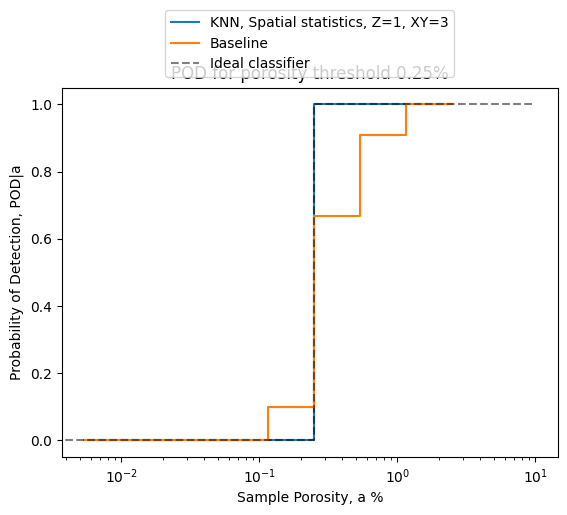

<Figure size 640x480 with 0 Axes>

In [65]:
import seaborn as sns

# sns.regplot(x=x, y=y, data=df, logistic=True, ci=None)
plt.figure()
for key in scoresMap.keys():
    Ypred, Yprobs = scoresMap[key]
    Ytest = np.array(testobjectinfo.loc[:,"Label"])
    limits = np.logspace(-2, 1, num=10)*threshold
    recall = [metrics.recall_score(np.where((testobjectinfo.Porosity < limit1) & (testobjectinfo.Porosity > limit2), 1, 0), Ypred) for (limit1, limit2) in zip(limits[1:], limits[:-1]) ]
    plt.step(limits[1:], recall, where='pre', label=key)
    # print([np.sum(np.where(testobjectinfo.Porosity > limit, 1, 0)) for limit in limits])
    # print(np.sum(Ypred))
    # print(recall)
    # print(limits)
    # plt.plot(limits, recall, label=key)
    #define the predictor variable and the response variable

plt.plot([0, threshold, threshold, 10], [0, 0, 1, 1], label= "Ideal classifier", linestyle='dashed', c='black', alpha=0.5)
plt.xlabel("Sample Porosity, a %")
plt.ylabel("Probability of Detection, POD|a")
plt.xscale('log')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fancybox=True)
title = "POD for porosity threshold " + str(threshold) + "%"
plt.savefig('figures/v3plotter/A/POD' + str(threshold) + '.png', dpi=300, bbox_inches='tight')
plt.title(title)
plt.figure()

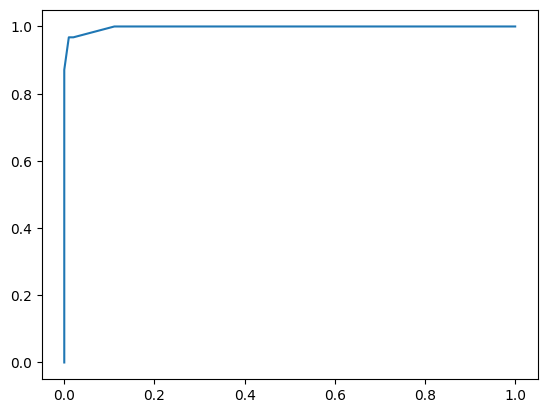

In [119]:
# Temporary cell to investigate perfect result

settings =  pd.DataFrame([
    # [0.25, 'KNN', 'spatstat', 1, 3, 40],
    [0.25, 'KNN', 'moran', 1, 5, 5],
], columns=settingcolumns)

# for threshold in [0.5, 0.25, 0.1]:
for threshold in [0.25]:
    # trainobjects, trainobjectinfo, testobjects, testobjectinfo = getTrainObjects(porositythreshold=threshold, objectsplit=3, separate_test=False)
    scoresMap = {}
    for index, object in settings[settings.threshold == threshold].iterrows():
        name = "Moran scatter plot" if object.type == "moran" else "Spatial statistics" if object.type == "spatstat" else "Scatter plot"
        Ypred, Yprobs, neighbours = getPodAndRoc(trainobjects, trainobjectinfo, testobjects, testobjectinfo, object.classifier, object.type, object.z, object.xy, object.bins)
        Ytest = np.array(testobjectinfo.loc[:,"Label"])
        fpr , tpr, thresholds = roc_curve(Ytest, Yprobs)
        auc = roc_auc_score(Ytest, Yprobs)
        f1 = metrics.f1_score(Ytest, Ypred)
        hashname = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy}'
        # label = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy}, Bins={object.bins} (AUC={auc:.3f}, F1={f1:.3f})'
        label = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy} (AUC={auc:.3f})'
        scoresMap[hashname] = (Ypred, Yprobs)
        plt.plot(fpr, tpr, label=label)


In [120]:
# Investigating ??

distance = neighbours[0]
nodes = neighbours[1]

for index, node in enumerate(nodes):
    print(testobjectinfo.iloc[index].Label, testobjectinfo.iloc[index].Object, testobjectinfo.iloc[index].Segment, trainobjectinfo.iloc[node][['Object', 'Segment', 'Label']])

# Investigation into the combination producing a perfect result
# The combination producing a perfect result is KNN, spatstat, Z=1, XY=3, Bins=40. The k in k-nn (i..e the number of neighbours voting) is 5. Although it is somewhat hard to concisely visualise which segments of which objects contributed, below is a summary. For each of the predictions, I look at how often the neighbours voting came from the same object (i.e. for segment HS1 (the smallest segment) in object H1, how many of the neighbours voting were from H1?), how many came from the same segment (for segment HS1 (the smallest segment) in object H1, how many of the neighbours voting were from segment HS1?) and finally how many were from both (for segment HS1 (the smallest segment) in object H1, how many of the neighbours voting were from segment HS1 in object H1?).

x = np.array([0, 0, 0, 0, 0, 0])

for index, node in enumerate(nodes):
    # check if the neighbours were from same object
    n = trainobjectinfo.iloc[node]
    t = testobjectinfo.iloc[index]
    i = n.loc[n['Object'] == t.Object].shape[0]
    x[i] += 1
print("Same object:", x)
print("Expected number of same object if random:", 5/26 , "Expected knowing this distribution:", np.sum(x[1:]*np.arange(1,6))/len(nodes))

x = np.array([0, 0, 0, 0, 0, 0])

for index, node in enumerate(nodes):
    # check if the neighbours were from same object
    n = trainobjectinfo.iloc[node]
    t = testobjectinfo.iloc[index]
    i = n.loc[n['Segment'] == t.Segment].shape[0]
    x[i] += 1
print("Same segment:", x)
print("Expected number of same segment if random:", 5/5 , "Expected knowing this distribution:", np.sum(x[1:]*np.arange(1,6))/len(nodes))

x = np.array([0, 0, 0, 0, 0, 0])

for index, node in enumerate(nodes):
    # check if the neighbours were from same object
    n = trainobjectinfo.iloc[node]
    t = testobjectinfo.iloc[index]
    i = n.loc[(n['Segment'] == t.Segment) & (n['Object'] == t.Object)].shape[0]
    x[i] += 1
print("Same segment and object:", x)
print("Expected number of same segment and object if random:", 5/(26*5) , "Expected knowing this distribution:", np.sum(x[1:]*np.arange(1,6))/len(nodes))

0 H1 1     Object  Segment  Label
225    H20        1      0
235    H23        1      0
180    H11        1      0
110    H24        1      0
240    H24        1      0
0 H1 2     Object  Segment  Label
11      H3        2      0
131     H1        2      0
96     H20        2      0
201    H15        2      0
156     H6        2      0
0 H1 3     Object  Segment  Label
182    H11        3      0
12      H3        3      0
132     H1        3      0
72     H15        3      0
157     H6        3      0
0 H1 4     Object  Segment  Label
228    H20        4      0
73     H15        4      0
253    H26        4      0
4       H1        5      0
158     H6        4      0
0 H1 5     Object  Segment  Label
127    H27        3      0
54     H11        5      0
134     H1        5      0
98     H20        4      0
203    H15        4      0
1 H2 1     Object  Segment  Label
167     H8        3      1
5       H2        1      1
37      H8        3      1
169     H8        5      1
6       H2   

In [121]:
LARGE = 64


plt.rc('font', size=64)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure()

for key in scoresMap.keys():
        Ypred, Yprobs = scoresMap[key]
        Ytest = np.array(testobjectinfo.loc[:,"Label"])
        cm = metrics.confusion_matrix(Ytest, Ypred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Solid", "Porous"])
        disp.plot()
        title = "Confusion matrix for threshold: " + str(threshold) +  ", " + key
        plt.savefig('figures/' + title + '.png', dpi=300, bbox_inches='tight')
        # plt.title(title)
        # plt.figure(figsize=(0.1,0.1), dpi=300)
        plt.figure
        plt.rcParams.update(plt.rcParamsDefault)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
# Testing the perfect classifiers

from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay


settingcolumns = ['threshold', 'classifier', 'type', 'z', 'xy', 'bins']
settings =  pd.DataFrame([
    # # [0.5, 'KNN', 'moran', 1, 7, 40],
    # [0.5, 'KNN', 'spatstat', 1, 3, 20],
    # [0.5, 'KNN', 'spatstat', 1, 5, 20],
    # [0.5, 'KNN', 'spatstat', 1, 7, 20],
    # # [0.5, 'KNN', 'spatstat', 1, 5, 10],
    [0.25, 'KNN', 'spatstat', 1, 5, 20],
    [0.25, 'KNN', 'spatstat', 1, 5, 20],
    [0.25, 'KNN', 'spatstat', 1, 7, 40],
    # # [0.10, 'KNN', 'moran', 7, 3, 20],
    # [0.10, 'KNN', 'spatstat', 1, 5, 5],
    # [0.10, 'KNN', 'moran', 7, 5, 40],
], columns=settingcolumns)
# for threshold in [0.5, 0.25, 0.1]:
for threshold in [0.25]:
    trainobjects, trainobjectinfo, testobjects, testobjectinfo = getTrainObjects(objectsplit=3, porositythreshold=threshold, separate_test=True)
    testobjects, testobjectinfo = getTestObjects(porositythreshold=threshold)
    scoresMap = {}
    for index, object in settings[settings.threshold == threshold].iterrows():
        name = "Moran scatter plot" if object.type == "moran" else "Spatial statistics" if object.type == "spatstat" else "Scatter plot"
        Ypred, Yprobs, neighbours = getPodAndRoc(trainobjects, trainobjectinfo, testobjects, testobjectinfo, object.classifier, object.type, object.z, object.xy, object.bins)
        Ytest = np.array(testobjectinfo.loc[:,"Label"])
        fpr , tpr, thresholds = roc_curve(Ytest, Yprobs)
        print(fpr, tpr, thresholds)
        auc = roc_auc_score(Ytest, Yprobs)
        f1 = metrics.f1_score(Ytest, Ypred)
        hashname = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy}'
        # label = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy}, Bins={object.bins} (AUC={auc:.3f}, F1={f1:.3f})'
        label = f'{object.classifier}, {name}, Z={object.z}, XY={object.xy} (AUC={auc:.3f})'
        scoresMap[hashname] = (Ypred, Yprobs)
        plt.plot(fpr, tpr, label=label, marker='x')
    
    Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
    Ytest = np.array(testobjectinfo.loc[:,"Label"])
    Xtrain = np.array([np.nanmean(object) for object in trainobjects])
    Xtest = np.array([np.nanmean(object) for object in testobjects])
    clf = tree.DecisionTreeClassifier(max_depth=1)
    clf.fit(Xtrain.reshape(-1, 1), Ytrain)
    Ypred = clf.predict(Xtest.reshape(-1, 1))
    Yprobs = clf.predict_proba(Xtest.reshape(-1, 1))[:,1]
    
    auc = roc_auc_score(Ytest, Yprobs)
    fpr , tpr, thresholds = roc_curve(Ytest, Yprobs)
    f1 = metrics.f1_score(Ytest, Ypred)
    # label = f'Baseline (AUC={auc:.3f}, F1={f1:.3f})'
    label = f'Baseline (AUC={auc:.3f})'
    hashname = 'Baseline'
    plt.plot(fpr, tpr, label=label, marker='x')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fancybox=True)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis('square')
    title = "ROC for threshold " + str(threshold)
    plt.savefig('figures/v3plotter/B/roc_' + str(threshold) + '.png', dpi=300, bbox_inches='tight')
    plt.title(title)
    plt.figure()
    scoresMap[hashname] = (Ypred, Yprobs)
    plt.rc('font', size=48)          # controls default text sizes
    plt.rc('axes', titlesize=24)     # fontsize of the axes title
    plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=24)    # fontsize of the tick labels

    # Confusion matricies
    for key in scoresMap.keys():
        Ypred, Yprobs = scoresMap[key]
        Ytest = np.array(testobjectinfo.loc[:,"Label"])
        cm = metrics.confusion_matrix(Ytest, Ypred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Solid", "Porous"])
        disp.plot()
        title = "Confusion matrix for threshold: " + str(threshold) +  ", " + key
        plt.savefig('figures/v3plotter/B/confusionmatrix_' + str(threshold) + "_" + key + '.png', dpi=300, bbox_inches='tight')
        plt.title(title)
        plt.figure()
    plt.rcParams.update(plt.rcParamsDefault)

    # Precision recall plot
    for key in scoresMap.keys():
        Ypred, Yprobs = scoresMap[key]
        Ytest = np.array(testobjectinfo.loc[:,"Label"])
        precision, recall, thresholds = metrics.precision_recall_curve(Ytest, Yprobs)
        plt.plot(recall, precision, label=key)
    plt.axis('square')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fancybox=True)
    title = "precision-recall plot for porosity threshold " + str(threshold) + "%"
    plt.savefig('figures/v3plotter/B/precision-recall' + str(threshold) + '.png', dpi=300, bbox_inches='tight')
    plt.title(title)
    plt.figure()

    # POD plot
    limits = np.logspace(-2, 2, num=13)*threshold
    newlimits = np.copy(limits)
    minporosity = np.min(testobjectinfo.Porosity)
    maxporosity = np.max(testobjectinfo.Porosity)
    for index in reversed(range(len(limits))):
        limit = limits[index]
        # If not first element...
        if (index + 1) > 0:
            # if the current element is higher than the largest porosity, remove the rest
            if limit > maxporosity:
                newlimits = limits[:index+1]
                break
    limits = np.copy(newlimits)
    for index in range (len(limits)):
        limit = limits[index]
        # If not last element...
        if (index + 1) < len(limits):
            # if the current element is smaller than the smallest porosity, remove the rest
            if limit < minporosity:
                newlimits = limits[index:]
                break
    limits = newlimits
    
    plt.grid()
    for (index, key) in enumerate(scoresMap.keys()):
        Ypred, Yprobs = scoresMap[key]
        Ytest = np.array(testobjectinfo.loc[:,"Label"])
        recall = [metrics.recall_score(np.where((testobjectinfo.Porosity < limit1) & (testobjectinfo.Porosity > limit2), 1, 0), Ypred, zero_division=1) for (limit1, limit2) in zip(limits[1:], limits[:-1]) ]
        plt.step(limits[1:], recall, where='pre', label=key, linestyle=(-index*2, (3, 5)), zorder=10-index, linewidth=3, alpha=0.8)
    plt.plot([0, threshold, threshold, limits[-1]], [0, 0, 1, 1], label= "Ideal classifier", linestyle=(-4, (4, 5)), c='black', zorder=0)
    plt.xlabel("Sample Porosity, a %")
    plt.ylabel("Probability of Detection, POD|a")
    plt.xscale('log')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fancybox=True)
    title = "POD for porosity threshold " + str(threshold) + "%"
    plt.savefig('figures/v3plotter/B/POD' + str(threshold) + '.png', dpi=300, bbox_inches='tight')
    plt.title(title)
    plt.figure()